In [2]:
import os
import torch
import numpy as np

from conditional_rate_matching.models.generative_models.crm import CRM
from conditional_rate_matching.utils.plots.images_plots import mnist_noise_bridge, mnist_grid
from conditional_rate_matching import results_path
from conditional_rate_matching import plots_path
from conditional_rate_matching.models.metrics.fid_metrics import load_classifier
from conditional_rate_matching.models.metrics.fid_metrics import fid_nist
from conditional_rate_matching.models.pipelines.sdes_samplers.samplers import TauLeaping

import matplotlib.pyplot as plt
from torchvision.utils import make_grid


def test_mnist_maps_batch_example(experiment_dir, 
                                  device, 
                                  class_label=None,
                                  time_epsilon = 0.05,
                                  num_timesteps = 100,
                                  number_of_images_to_see=3, 
                                  steps_of_noise_to_see=20):
    """
    just one sample from source and classification
    """
    from conditional_rate_matching.utils.data.samples import select_label
    device = torch.device(device)
    crm = CRM(experiment_dir=experiment_dir, device=device)

    classifier = load_classifier(crm.config.data1.dataset_name, device)
    crm.config.pipeline.time_epsilon = time_epsilon
    crm.config.pipeline.num_intermediates = steps_of_noise_to_see
    crm.config.pipeline.number_of_steps = num_timesteps

    if class_label is not None:
        selected_images = select_label(crm.dataloader_0,
                                   label_to_see=class_label,
                                   sample_size=number_of_images_to_see,
                                   train=True)
        num_images_encountered = selected_images.size(0)
        x_f, x_hist, ts = crm.pipeline(100, return_intermediaries=True, train=False, x_0=selected_images)
    else:
        num_images_encountered = number_of_images_to_see + 1
        x_f, x_hist, ts = crm.pipeline(number_of_images_to_see, return_intermediaries=True, train=False)

    mnist_noise_bridge(x_hist, ts, steps_of_noise_to_see, min(num_images_encountered, number_of_images_to_see),
                       save_path=None)
    y = classifier(x_f.view(-1, 1, 28, 28))
    y = torch.argmax(y, dim=1)
    print(y)


def get_mnist_test_samples(trained_model, 
                           class_label=None, 
                           sample_size=800, 
                           device="cpu"):
    
    experiment_dir = os.path.join(results_path,"crm", trained_model)
    crm = CRM(experiment_dir=experiment_dir, device=device)
    images = []
    for batch in crm.dataloader_0.test():
        if len(batch) == 2:
            sample, labels = batch[0], batch[1]
            selected_images = sample[labels == class_label] if class_label is not None else sample 
            images.append(selected_images)
        else:
            sample = batch[0].view(-1, 1, 28, 28)
            images.append(sample)

    return torch.cat(images, dim=0)[:sample_size].to(device) #if labeled else torch.tensor(images, device=device)

def generate_samples(trained_model, 
                     x_test,
                     num_timesteps=100, 
                     time_epsilon=0.0,
                     device="cpu"):
    
    experiment_dir = os.path.join(results_path,"crm", trained_model)
    crm = CRM(experiment_dir=experiment_dir, device=device)
    crm.config.pipeline.time_epsilon = time_epsilon
    crm.config.pipeline.num_intermediates = num_timesteps
    crm.config.pipeline.number_of_steps = num_timesteps

    x_1, x_t, t = crm.pipeline(10000, 
                               return_intermediaries=True, 
                               train=False, 
                               x_0=x_test)
    
    x_1 = x_1.view(-1, 1, 28, 28)
    x_t = x_t.view(-1, x_t.shape[1], 1, 28, 28)
    return x_1, x_t, t

def generate_mnist_samples(trained_model, 
                           num_timesteps=100, 
                           class_label=None, 
                           time_epsilon=0.0,
                           sample_size=800, 
                           device="cpu"):
    
    experiment_dir = os.path.join(results_path,"crm", trained_model)
    crm = CRM(experiment_dir=experiment_dir, device=device)
    images = []
    for batch in crm.dataloader_0.test():
        if len(batch) == 2:
            sample, labels = batch[0], batch[1]
            selected_images = sample[labels == class_label] if class_label is not None else sample 
            images.append(selected_images)
        else:
            sample = batch[0].view(-1, 1, 28, 28)
            images.append(sample)

    x_0 = torch.cat(images, dim=0)[:sample_size].to(device) #if labeled else torch.tensor(images, device=device)
    crm.config.pipeline.time_epsilon = time_epsilon
    crm.config.pipeline.num_intermediates = num_timesteps
    crm.config.pipeline.number_of_steps = num_timesteps

    x_1, x_t, t = crm.pipeline(sample_size, 
                               return_intermediaries=True, 
                               train=False, 
                               x_0=x_0)
    
    x_1 = x_1.view(-1, 1, 28, 28)
    x_t = x_t.view(-1, x_t.shape[1], 1, 28, 28)
    images = []

    return x_1, x_t, t


def mnist_classifier(img, plot_histogram=False, device="cpu"):
    classifier = load_classifier('mnist', device=device)
    classifier = classifier.to(device)
    classifier.eval()
    y = classifier(img)
    classes = torch.argmax(y, dim=1).cpu().numpy()
    classes = classes.tolist()
    if plot_histogram:
        plt.subplots(figsize=(2.5,2.5))
        unique, counts = np.unique(classes, return_counts=True)
        plt.bar(unique, counts)
        plt.xticks(range(10))
        plt.show()
    else:
        return classes
    


def mnist_grid(sample, num_img=5):
    sample = sample[:num_img]
    img = make_grid(sample)
    npimg = np.transpose(img.detach().cpu().numpy(),(1,2,0))
    plt.imshow(npimg)
    plt.axis('off')
    plt.show()



def mnist_noise_bridge(img_1, 
                       img_hist,
                       time_steps, 
                       num_img,
                       num_timesteps_displayed=20,
                       save_path=None):
    
    _, axs = plt.subplots(num_img, num_timesteps_displayed+2, figsize=(num_timesteps_displayed, num_img))

    N = img_hist.size(1)
    dt = N // num_timesteps_displayed
    
    for j, idx in enumerate(np.arange(0, N+1, dt)):
        if j<num_timesteps_displayed:
            tau = time_steps[idx]
            images = img_hist[:, idx, :]
        else:
            tau = time_steps[-1]
            images = img_hist[:, -1, :]
            
        for i in range(num_img):
            img = images[i].detach().cpu().numpy()
            axs[i, j].imshow(img.squeeze(), cmap='gray')
            if i == 0: axs[i, j].set_title(r'$\tau = {0}$'.format(round(tau.item(),2)))
            axs[i, j].axis('off')
    
    j = num_timesteps_displayed + 1
    for i in range(num_img):
        axs[i, j].imshow(img_1[i].detach().cpu().numpy().squeeze(), cmap='gray')
        axs[i, j].axis('off')

    plt.tight_layout()
    if save_path is None: plt.show()
    else: plt.savefig(save_path)


/home/df630/.conda/envs/conditional_rate_matching/lib/python3.10/site-packages/tqdm-4.66.1-py3.10.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. NOISE $\to$ MNIST

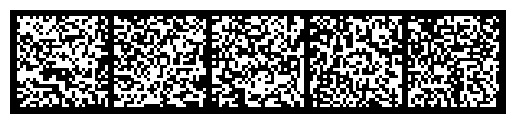

In [10]:
model = "mnist/my_unet/mnist_unet_128x128_0.05/run"
noise = get_mnist_test_samples(model, class_label=None, sample_size=10000, device="cuda:1")
# mnist_grid(noise, num_img=5)

INFO:  mnist/my_unet/mnist_unet_128x128_0.01/run


100%|██████████| 999/999 [00:08<00:00, 117.46it/s]


INFO:  mnist/my_unet/mnist_unet_128x128_0.05/run


100%|██████████| 999/999 [00:08<00:00, 117.28it/s]


INFO:  mnist/my_unet/mnist_unet_128x128_0.1/run


100%|██████████| 999/999 [00:08<00:00, 117.43it/s]


INFO:  mnist/my_unet/mnist_unet_128x128_0.25/run


100%|██████████| 999/999 [00:08<00:00, 119.64it/s]


INFO:  mnist/my_unet/mnist_unet_128x128_0.5/run


100%|██████████| 999/999 [00:08<00:00, 120.24it/s]


INFO:  mnist/my_unet/mnist_unet_128x128_0.75/run


100%|██████████| 999/999 [00:08<00:00, 120.18it/s]


INFO:  mnist/my_unet/mnist_unet_128x128_1.0/run


100%|██████████| 999/999 [00:08<00:00, 118.34it/s]


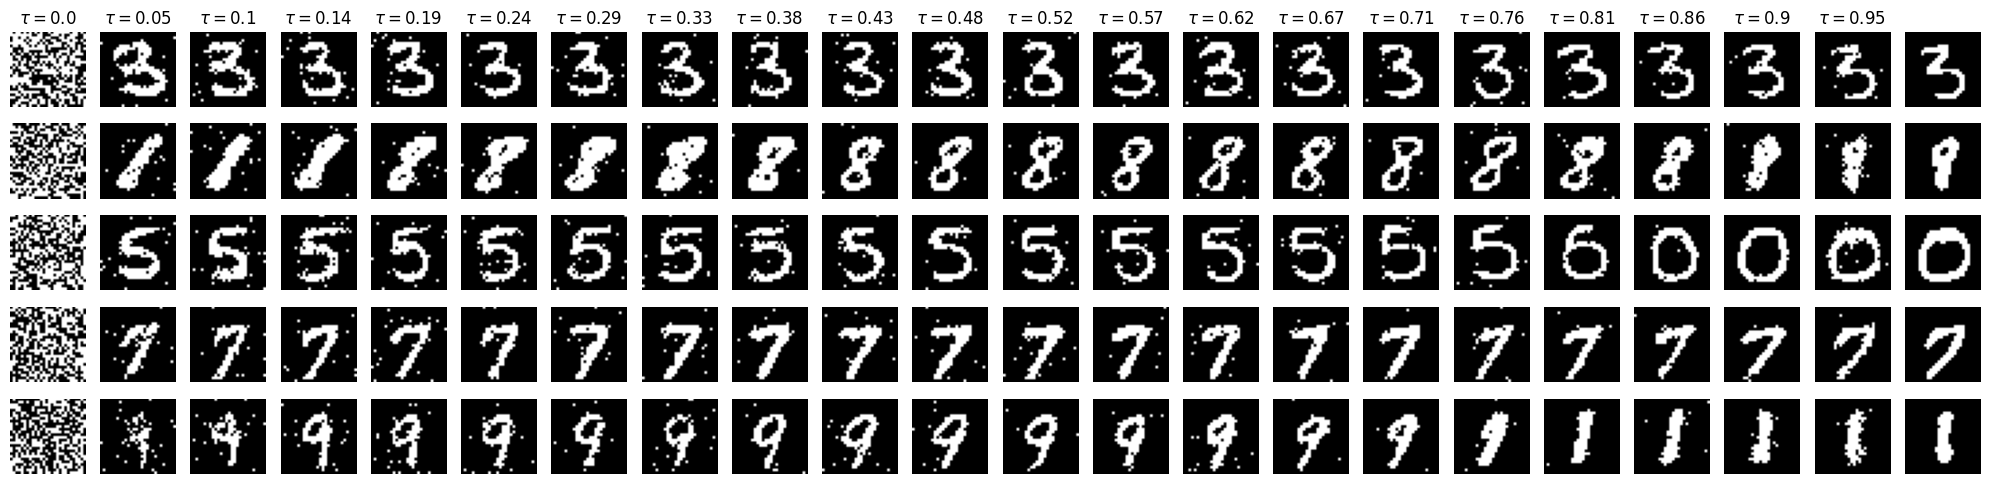

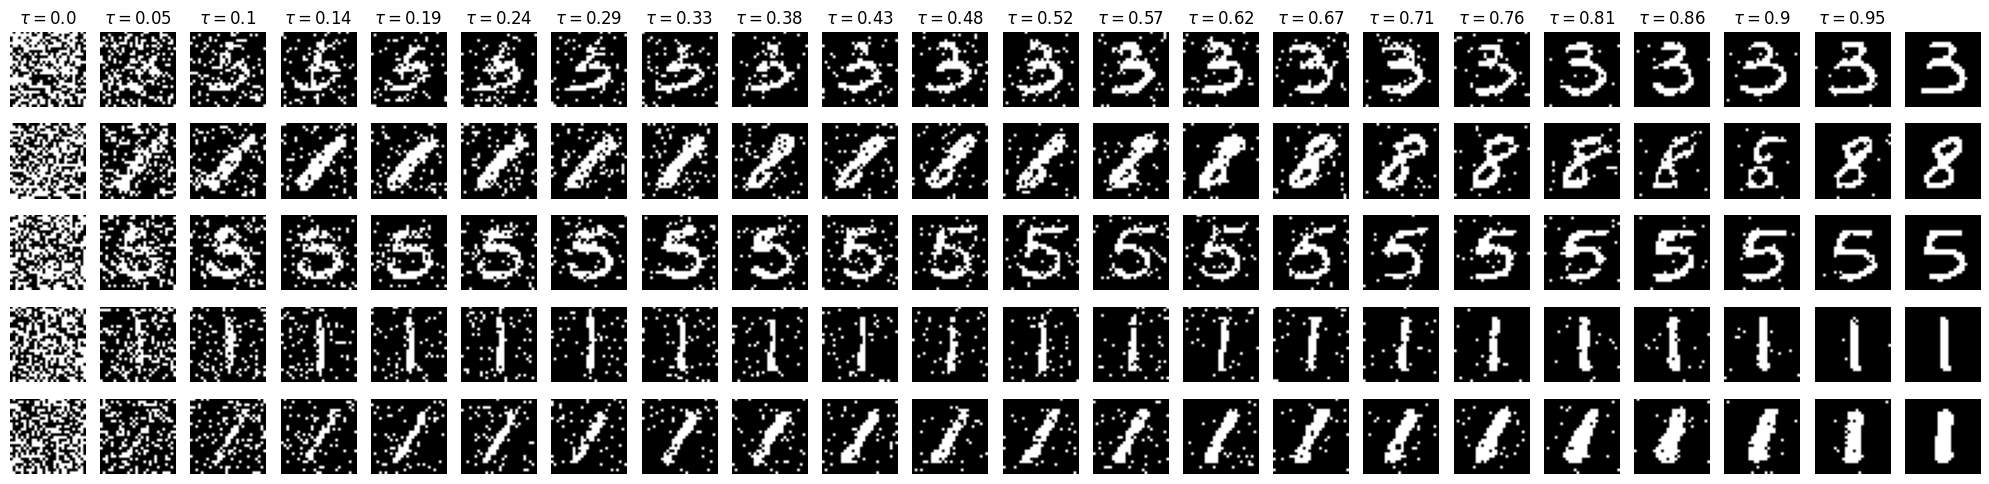

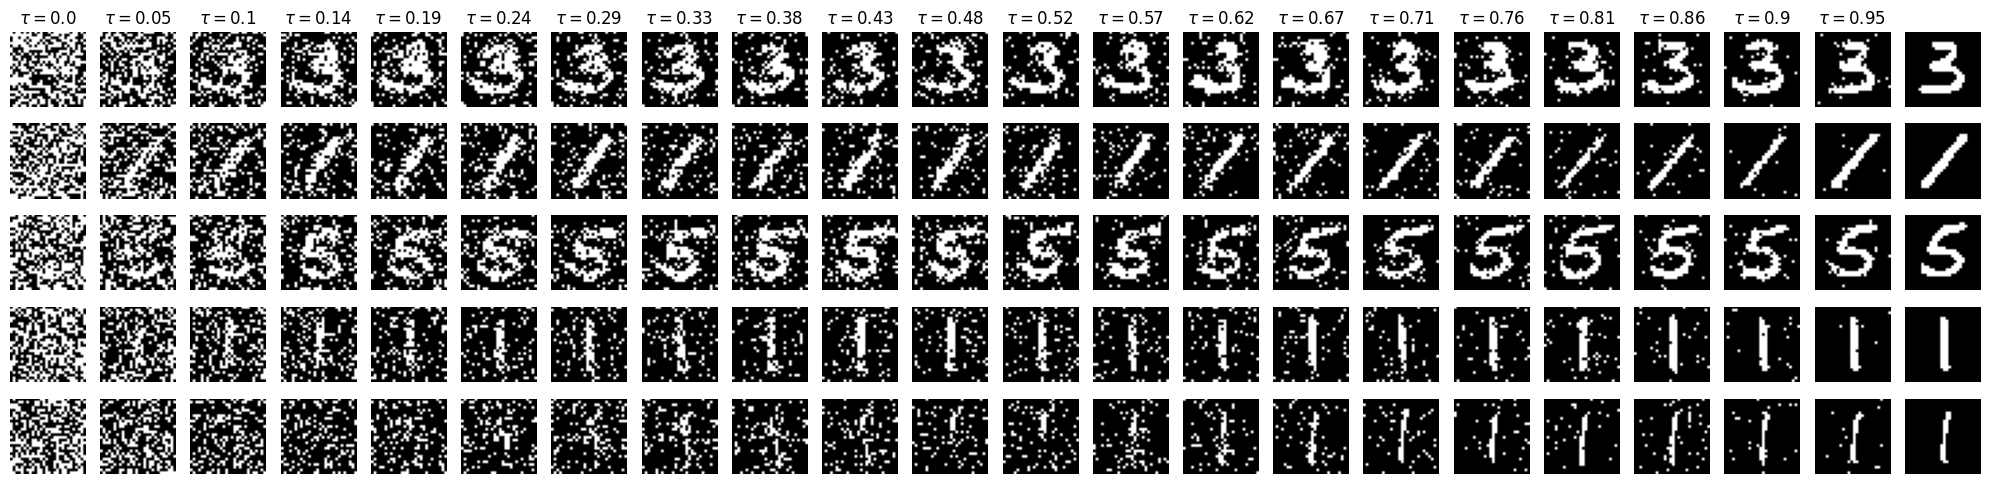

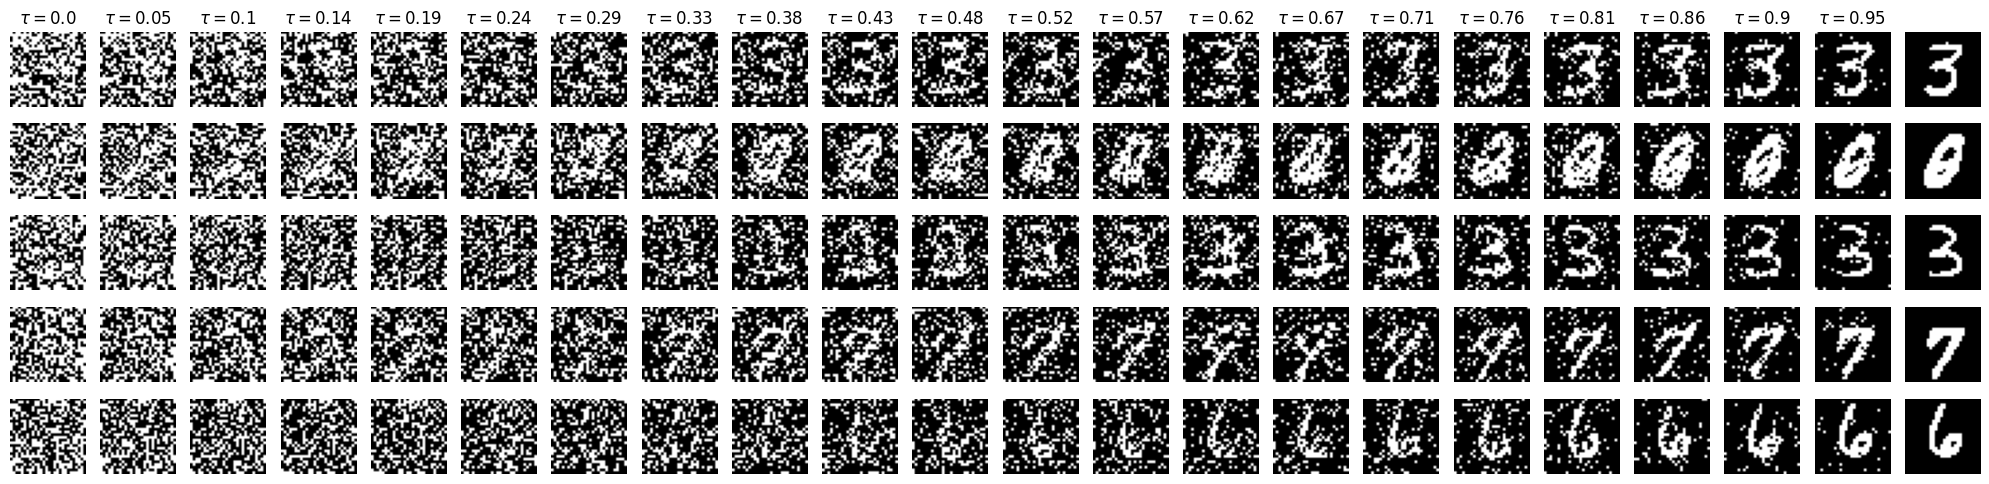

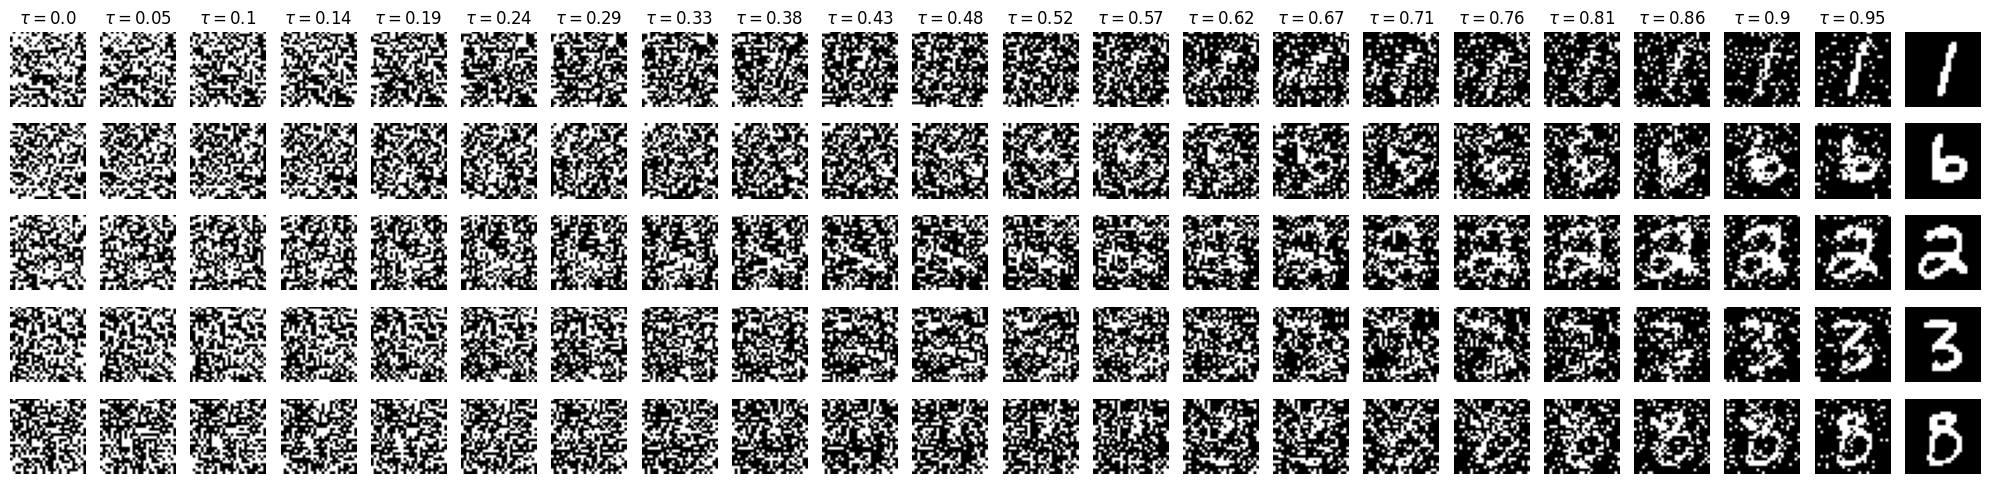

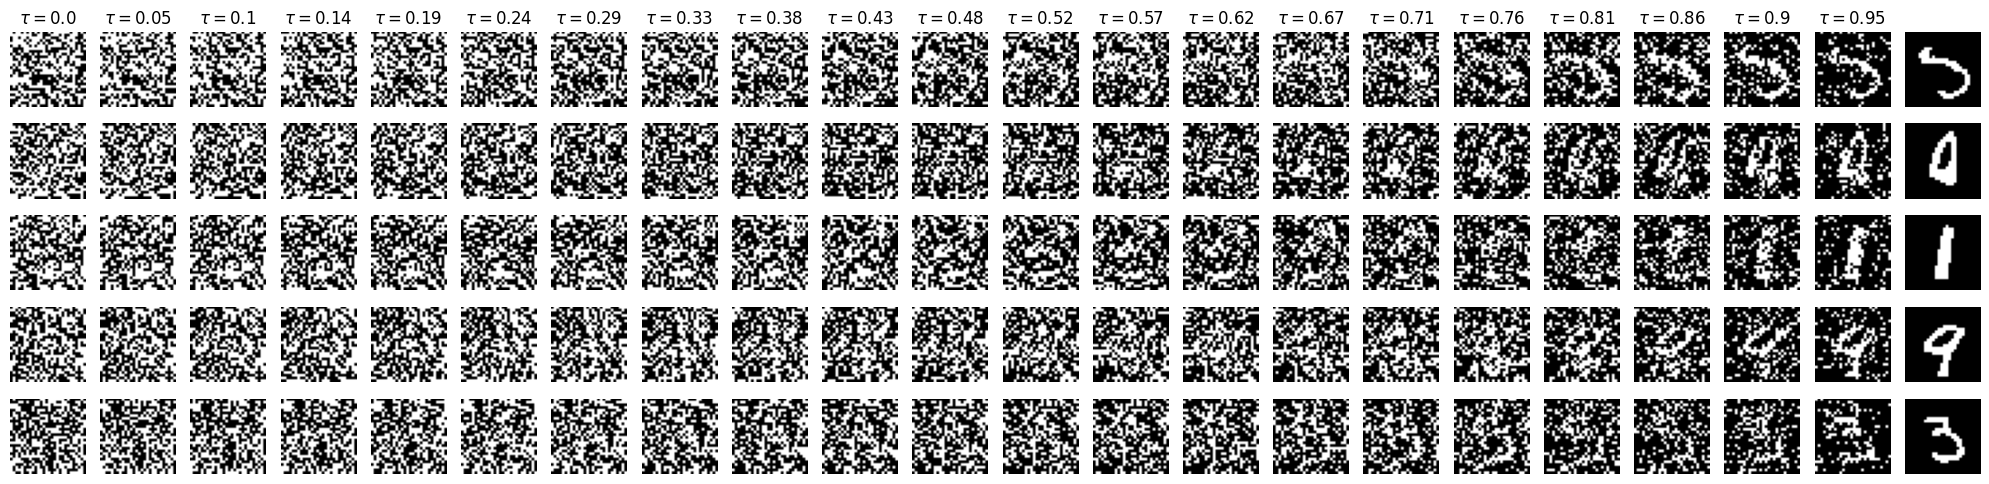

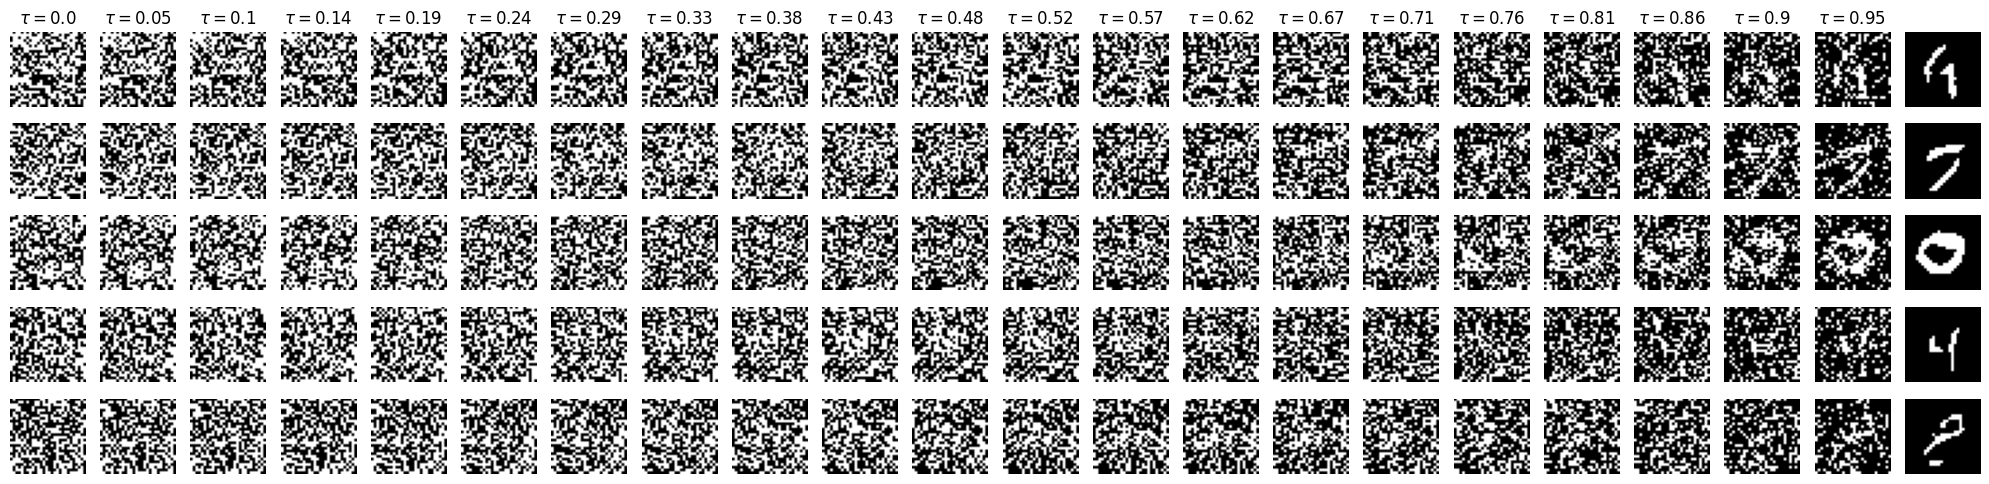

In [11]:
experiment = "mnist/my_unet/mnist_unet_128x128"
gen_samples = {0.01:{}, 0.05:{}, 0.1:{}, 0.25:{}, 0.5:{}, 0.75:{}, 1.0:{}}    

for gamma in list(gen_samples.keys()):
    path = experiment + '_' + str(gamma) +'/run'
    print('INFO: ', path )
    gen_samples[gamma] = generate_samples(path,  noise, num_timesteps=1000,  time_epsilon=0.05, device="cuda:1")
    mnist_noise_bridge(gen_samples[gamma][0], 
                       gen_samples[gamma][1], 
                       gen_samples[gamma][2], 
                       num_img=5, 
                       num_timesteps_displayed=20, 
                       save_path= os.path.join(results_path,"crm", path, "gen_sample_" + str(gamma) + ".png")) 

100%|██████████| 999/999 [00:27<00:00, 36.15it/s]


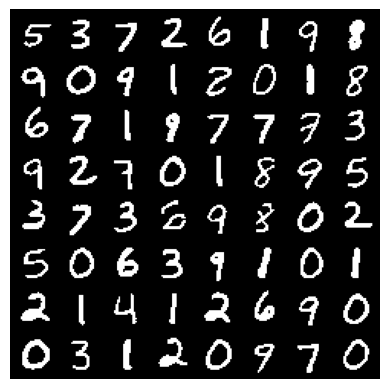

In [24]:

path = "mnist/my_unet/mnist_unet_128x128_0.05/run"
noise = get_mnist_test_samples(path, class_label=None, sample_size=64, device="cuda:1")
output, _, _= generate_samples(path,  noise, num_timesteps=1000,  time_epsilon=0.05, device="cuda:1")

mnist_grid(output, num_img=64)


100%|██████████| 999/999 [00:27<00:00, 36.48it/s]


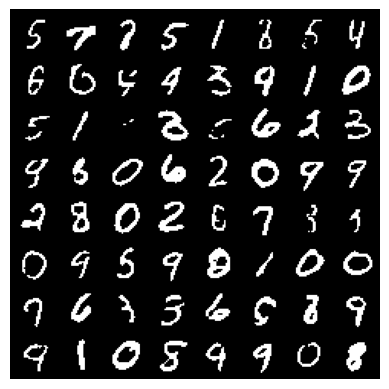

In [25]:
path = "mnist/my_unet/mnist_unet_128x128_1.0/run"
noise = get_mnist_test_samples(path, class_label=None, sample_size=64, device="cuda:1")
output, _, _= generate_samples(path,  noise, num_timesteps=1000,  time_epsilon=0.05, device="cuda:1")
mnist_grid(output, num_img=64)

# 2. Fashion MNIST $\to$ MNIST

In [66]:
mnist_grid(x1, num_img=10)


torch.Size([1, 1, 28, 28])

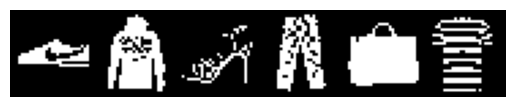

In [70]:
# mnist_grid(x0, num_img=5)
# mnist_grid(x1, num_img=5)
# mnist_grid(x2, num_img=5)
# mnist_grid(x3, num_img=5)
# mnist_grid(x4, num_img=5)
# mnist_grid(x5, num_img=5)
fashion = torch.cat([x5[2].unsqueeze(0), x1[0].unsqueeze(0), x0[0].unsqueeze(0), x2[3].unsqueeze(0), x3[1].unsqueeze(0), x4[2].unsqueeze(0)], dim=0)
mnist_grid(fashion, num_img=6)



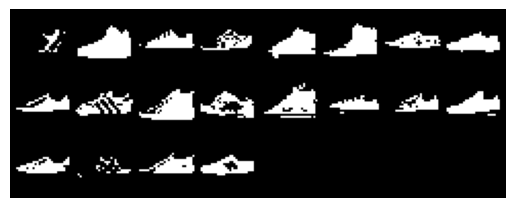

In [63]:
model = "fashion_2_mnist_bridge/my_unet/fashion_to_mnist_unet_128x128_0.05/run"
fashion = get_mnist_test_samples(model, class_label=7, sample_size=20, device="cuda:1")
mnist_grid(fashion, num_img=20)
           

INFO:  fashion_2_mnist_bridge/my_unet/fashion_to_mnist_unet_128x128_0.25/run


100%|██████████| 999/999 [00:11<00:00, 84.94it/s] 


INFO:  fashion_2_mnist_bridge/my_unet/fashion_to_mnist_unet_128x128_0.5/run


100%|██████████| 999/999 [00:08<00:00, 121.70it/s]


INFO:  fashion_2_mnist_bridge/my_unet/fashion_to_mnist_unet_128x128_0.75/run


100%|██████████| 999/999 [00:12<00:00, 82.47it/s] 


INFO:  fashion_2_mnist_bridge/my_unet/fashion_to_mnist_unet_128x128_1.0/run


100%|██████████| 999/999 [00:11<00:00, 84.62it/s] 


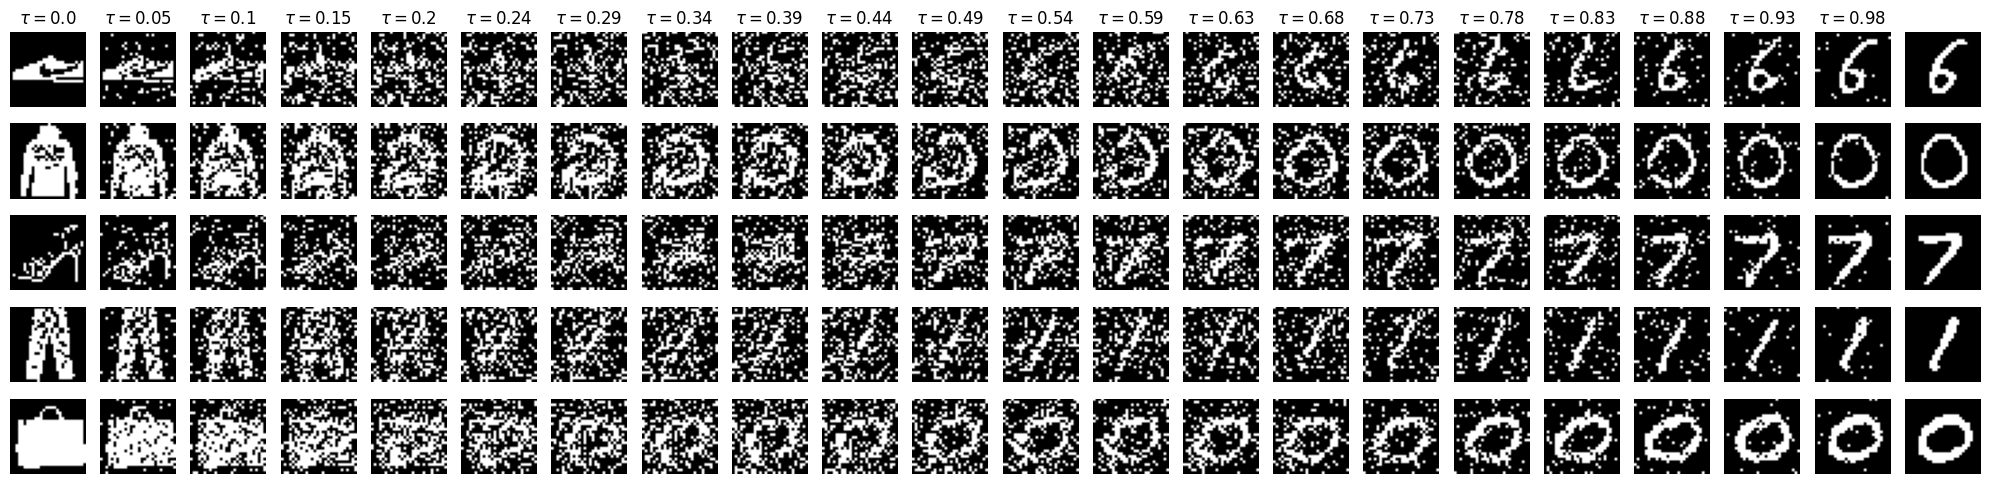

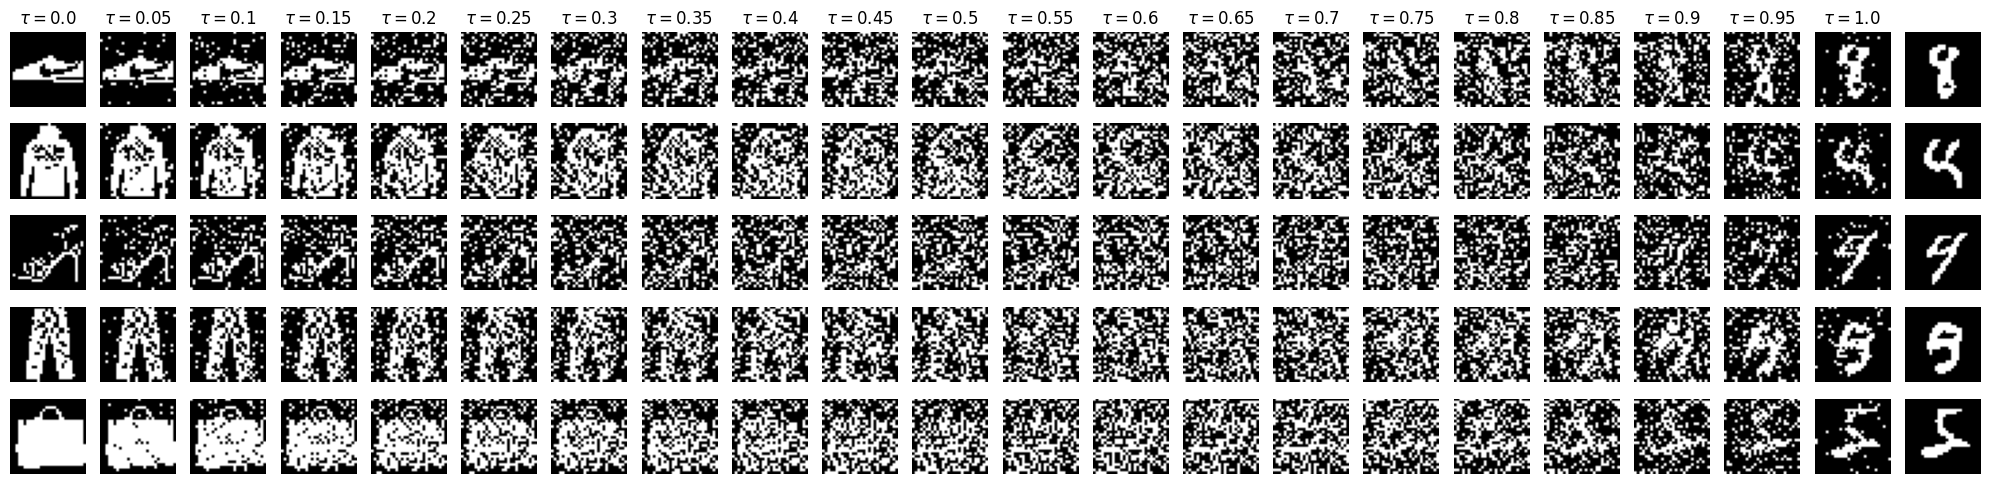

In [73]:
experiment = "fashion_2_mnist_bridge/my_unet/fashion_to_mnist_unet_128x128"
# gen_samples = {0.01:{}, 0.05:{}, 0.1:{}, 0.25:{}, 0.5:{}, 0.75:{}, 1.0:{}}   
# time_epislon = [0.05, 0.05, 0.05, 0.025, 0.01, 0.01, 0.01]  

gen_samples = { 0.25:{}, 0.5:{}, 0.75:{}, 1.0:{}}   
time_epislon = {0.25 : 0.025, 0.5 : 0.01, 0.75 : 0.01, 1.0 : 0.005}  


for gamma in list(gen_samples.keys()):
    path = experiment + '_' + str(gamma) +'/run'
    print('INFO: ', path )
    gen_samples[gamma] = generate_samples(path, fashion, num_timesteps=1000,  time_epsilon=time_epislon[gamma], device="cuda:1")
    mnist_noise_bridge(gen_samples[gamma][0], 
                       gen_samples[gamma][1], 
                       gen_samples[gamma][2], 
                       num_img=6, 
                       num_timesteps_displayed=20, 
                       save_path = os.path.join(results_path,"crm", path, "gen_sample_" + str(gamma) + ".png")) 

100%|██████████| 999/999 [00:27<00:00, 36.30it/s]


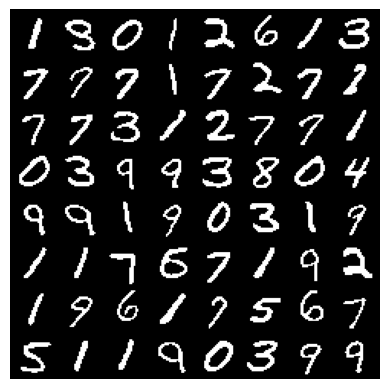

In [27]:
path = "fashion_2_mnist_bridge/my_unet/fashion_to_mnist_unet_128x128_0.05/run"
input = get_mnist_test_samples(path, class_label=None, sample_size=64, device="cuda:1")
output, _, _= generate_samples(path, input, num_timesteps=1000,  time_epsilon=0.05, device="cuda:1")
mnist_grid(output, num_img=64)

100%|██████████| 999/999 [00:27<00:00, 36.32it/s]


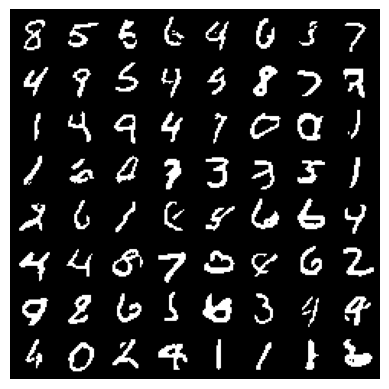

In [28]:
path = "fashion_2_mnist_bridge/my_unet/fashion_to_mnist_unet_128x128_1.0/run"
input = get_mnist_test_samples(path, class_label=None, sample_size=64, device="cuda:1")
output, _, _= generate_samples(path, input, num_timesteps=1000,  time_epsilon=0.05, device="cuda:1")
mnist_grid(output, num_img=64)

# 3. EMNIST $\to$ MNIST

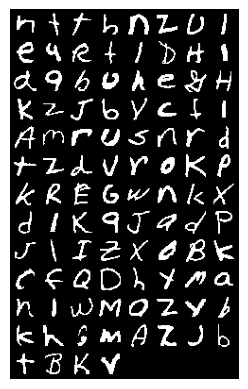

In [76]:
model = "emnist_2_mnist_bridge/my_unet/emnist_to_mnist_unet_128x128_0.05/run"
letters = get_mnist_test_samples(model, class_label=None, sample_size=100, device="cuda:1")
mnist_grid(letters, num_img=100)

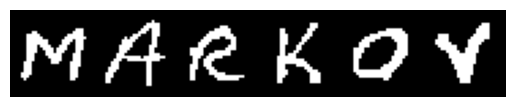

In [83]:
markov = torch.cat([letters[-17].unsqueeze(0), 
                    letters[32].unsqueeze(0),
                    letters[10].unsqueeze(0), 
                    letters[-2].unsqueeze(0), 
                    letters[-16].unsqueeze(0), 
                    letters[-1].unsqueeze(0)], dim=0)
mnist_grid(markov, num_img=6)

INFO:  emnist_2_mnist_bridge/my_unet/emnist_to_mnist_unet_128x128_0.01/run


100%|██████████| 999/999 [00:11<00:00, 84.27it/s] 


INFO:  emnist_2_mnist_bridge/my_unet/emnist_to_mnist_unet_128x128_0.05/run


100%|██████████| 999/999 [00:11<00:00, 87.32it/s] 


INFO:  emnist_2_mnist_bridge/my_unet/emnist_to_mnist_unet_128x128_0.1/run


100%|██████████| 999/999 [00:10<00:00, 92.33it/s] 


INFO:  emnist_2_mnist_bridge/my_unet/emnist_to_mnist_unet_128x128_0.25/run


100%|██████████| 999/999 [00:11<00:00, 84.47it/s]


INFO:  emnist_2_mnist_bridge/my_unet/emnist_to_mnist_unet_128x128_0.5/run


100%|██████████| 999/999 [00:11<00:00, 84.27it/s] 


INFO:  emnist_2_mnist_bridge/my_unet/emnist_to_mnist_unet_128x128_0.75/run


100%|██████████| 999/999 [00:11<00:00, 84.00it/s]


INFO:  emnist_2_mnist_bridge/my_unet/emnist_to_mnist_unet_128x128_1.0/run


100%|██████████| 999/999 [00:11<00:00, 84.23it/s] 


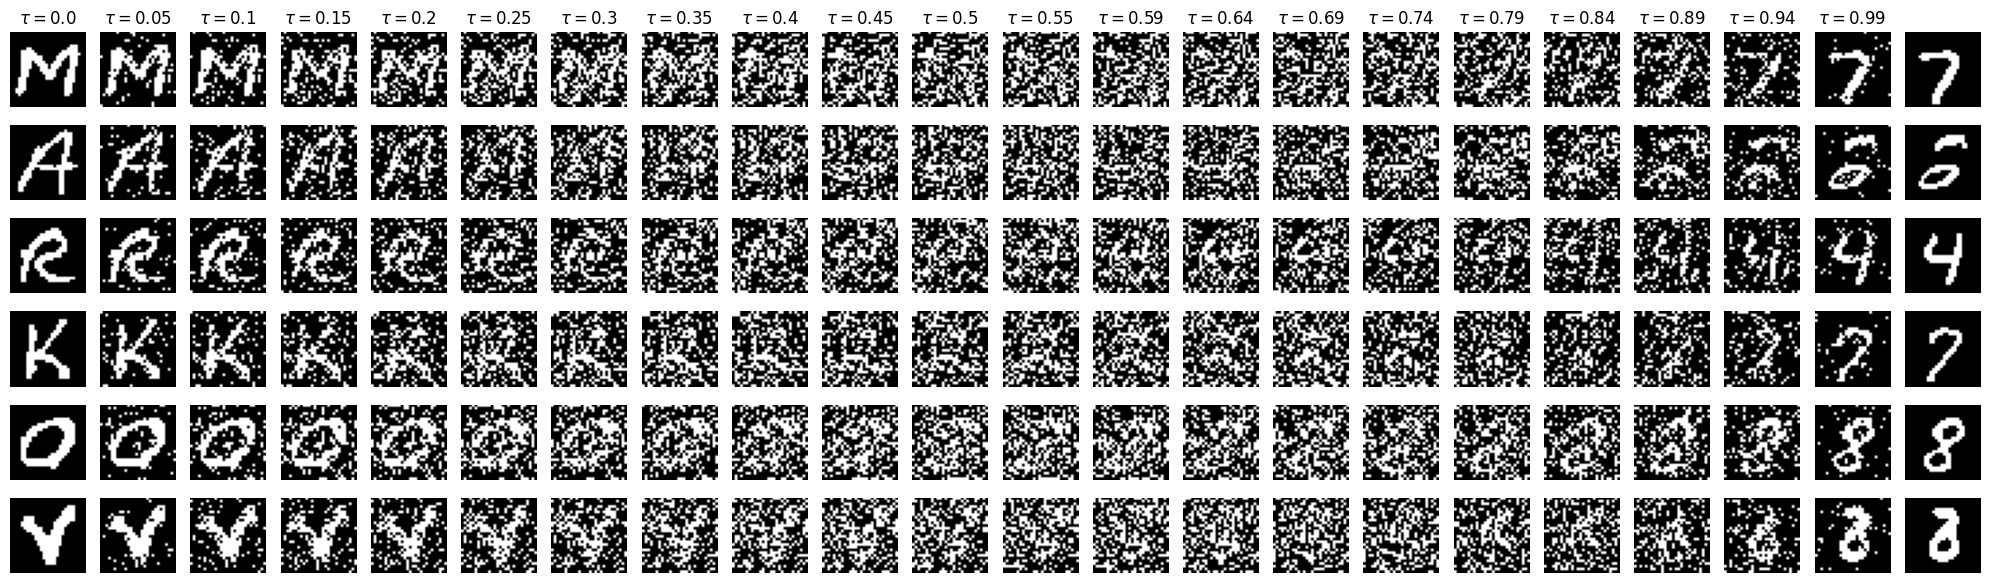

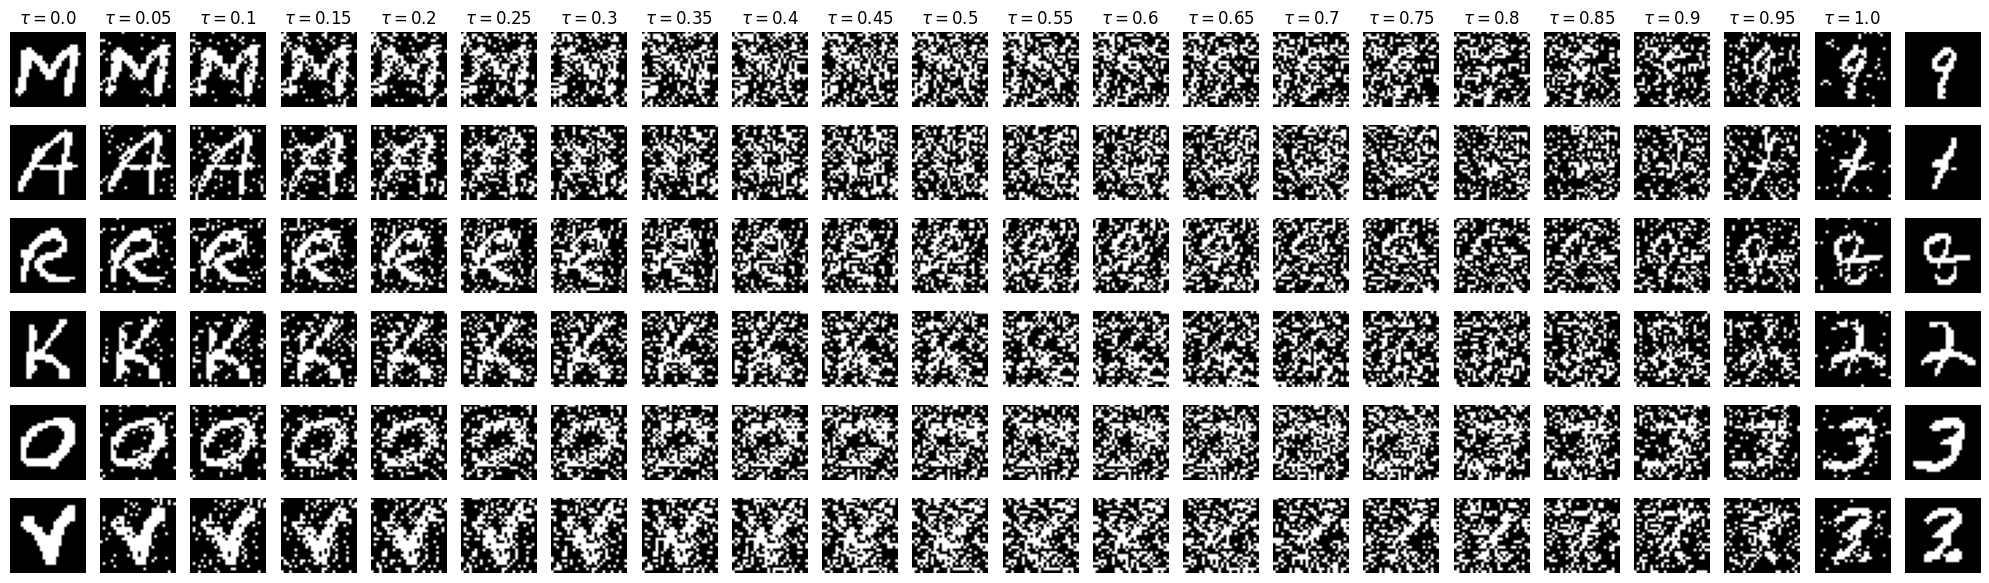

In [85]:
experiment = "emnist_2_mnist_bridge/my_unet/emnist_to_mnist_unet_128x128"
gen_samples = {0.01:{}, 0.05:{}, 0.1:{}, 0.25:{}, 0.5:{}, 0.75:{}, 1.0:{}}    
time_epislon = {0.01 : 0.05, 0.05 : 0.05, 0.1 : 0.05, 0.25 : 0.025, 0.5 : 0.01, 0.75 : 0.01, 1.0 : 0.005}  

for gamma in list(gen_samples.keys()):
    path = experiment + '_' + str(gamma) +'/run'
    print('INFO: ', path )
    gen_samples[gamma] = generate_samples(path, markov, num_timesteps=1000,  time_epsilon=time_epislon[gamma], device="cuda:1")
    mnist_noise_bridge(gen_samples[gamma][0], 
                       gen_samples[gamma][1], 
                       gen_samples[gamma][2], 
                       num_img=6, 
                       num_timesteps_displayed=20, 
                       save_path= os.path.join(results_path,"crm", path, "gen_sample_" + str(gamma) + ".png")) 

In [29]:
path = "emnist_2_mnist_bridge/my_unet/emnist_to_mnist_unet_128x128_0.05/run"
input = get_mnist_test_samples(path, class_label=None, sample_size=64, device="cuda:1")
output, _, _= generate_samples(path, input, num_timesteps=1000,  time_epsilon=0.05, device="cuda:1")
mnist_grid(output, num_img=64)

100%|██████████| 999/999 [00:27<00:00, 36.33it/s]


100%|██████████| 999/999 [00:27<00:00, 36.35it/s]


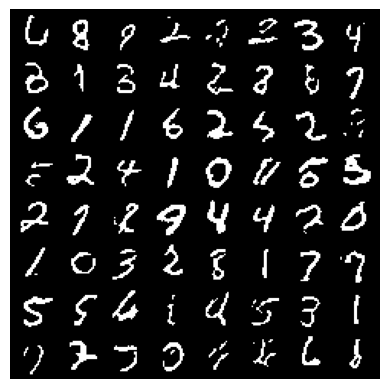

In [30]:
path = "emnist_2_mnist_bridge/my_unet/emnist_to_mnist_unet_128x128_1.0/run"
input = get_mnist_test_samples(path, class_label=None, sample_size=64, device="cuda:1")
output, _, _= generate_samples(path, input, num_timesteps=1000,  time_epsilon=0.05, device="cuda:1")
mnist_grid(output, num_img=64)

## periodic thermostat:


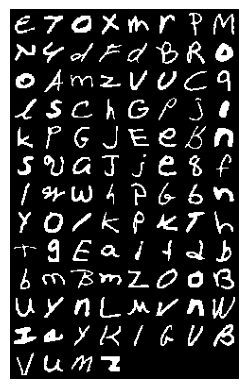

In [3]:
model = "emnist_to_mnist_unet_PeriodicThermostat_gamma_6.0_max_0.05/run"
letters = get_mnist_test_samples(model, class_label=None, sample_size=100, device="cuda:1")
mnist_grid(letters, num_img=100)

In [5]:
markov = torch.cat([letters[7].unsqueeze(0), 
                    letters[17].unsqueeze(0),
                    letters[14].unsqueeze(0), 
                    letters[-9].unsqueeze(0), 
                    letters[16].unsqueeze(0), 
                    letters[-4].unsqueeze(0)], dim=0)
mnist_grid(markov, num_img=6)

100%|██████████| 999/999 [00:20<00:00, 49.52it/s]


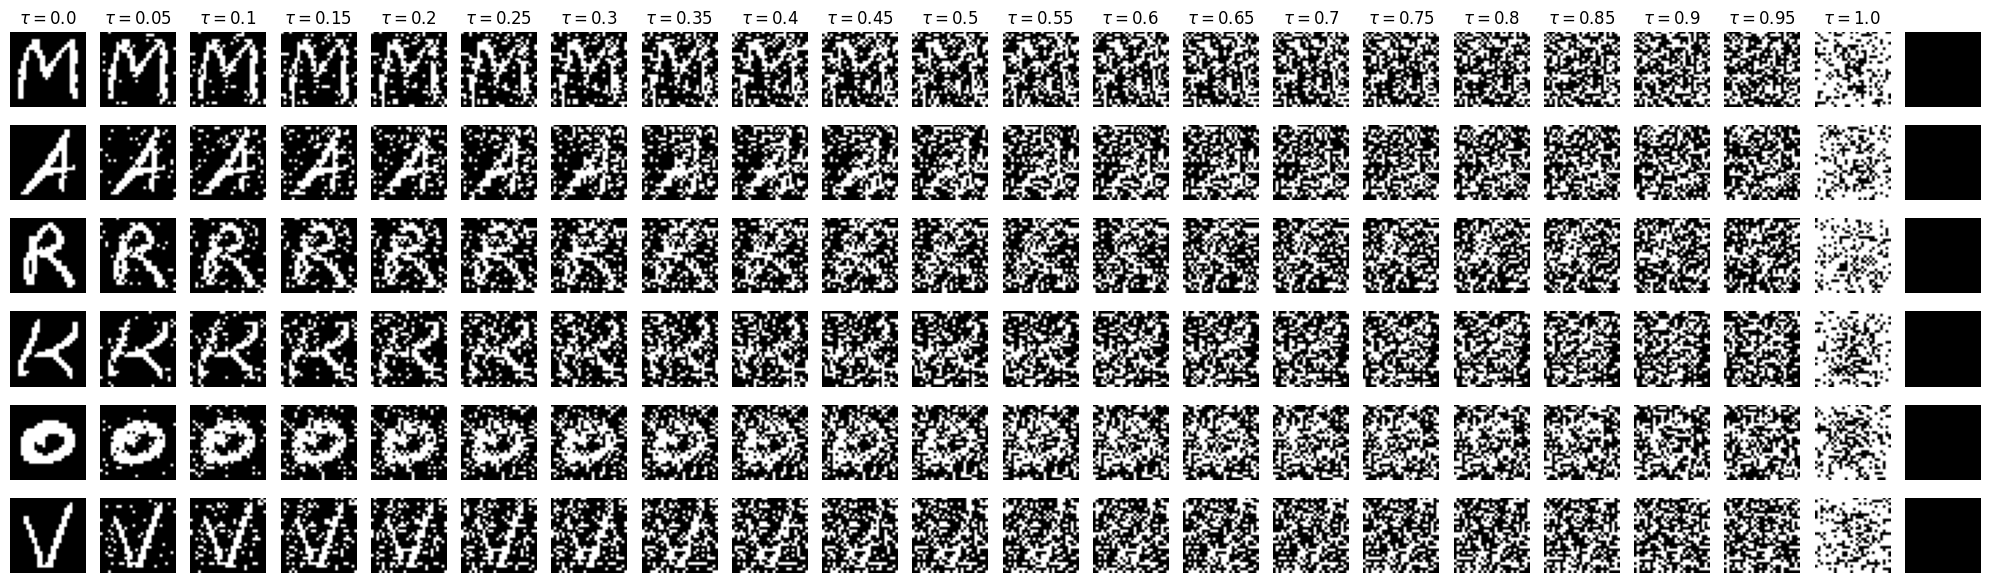

In [9]:
amplitude = 0.05
gamma = 6.0
time_epsilon = 0.0


path = "emnist_to_mnist_unet_PeriodicThermostat_gamma_" + str(gamma) + "_max_" + str(amplitude) +"/run"
gen_samples = generate_samples(path, markov, num_timesteps=1000,  time_epsilon=time_epsilon, device="cuda:1")
mnist_noise_bridge(gen_samples[0], 
                   gen_samples[1], 
                   gen_samples[2], 
                   num_img=6, 
                   num_timesteps_displayed=20, 
                   save_path= os.path.join(results_path,"crm", path, "gen_sample_" + str(gamma) + '_' + str(amplitude) + ".png")) 